[주제]
무역 품목 간 공행성 쌍 판별 및 후행 품목 무역량 예측 AI 모델 개발

[설명] 원시 무역 수입 데이터(2022년 1월 ~ 2025년 7월)를 기반으로, 품목 간 공행성(comovement)이 존재하는 선후행 쌍을 예측하고, 공행성이 있다고 판단된 경우에는 후행 품목의 다음 달(2025년 8월) 총 무역량(value)을 예측하는 AI 모델을 개발합니다.

참가자는 주어진 원시 무역 데이터를 분석하여 품목 간 선후행 관계가 존재하는 공행성 쌍(A → B)을 찾아야 하며, 이후에는 선행 품목(A)의 흐름을 활용해 후행 품목(B)의 다음달의 총 무역량(value)을 예측해야 합니다.

### 1. Import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

### 2. 데이터 로딩

In [4]:
train = pd.read_csv("train.csv", encoding='utf-8')
print(train.shape)
train.head(3)

(10836, 9)


,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0


In [5]:
submission = pd.read_csv("sample_submission.csv")

print(submission.shape)
submission.head(5)

(9900, 3)


,leading_item_id,following_item_id,value
0,DEWLVASR,ELQGMQWE,999999999
1,DEWLVASR,AHMDUILJ,999999999
2,DEWLVASR,XIPPENFQ,999999999
3,DEWLVASR,FTSVTTSR,999999999
4,DEWLVASR,XMKRPGLB,999999999


In [6]:
print(train.columns)
train.info()
train.describe(include="all").T.head(20)

Index(['item_id', 'year', 'month', 'seq', 'type', 'hs4', 'weight', 'quantity',
       'value'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 762.0+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
item_id,10836,100,ELQGMQWE,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,10836.0,NaN,NaN,NaN,2023.331395,1.049357,2022.0,2022.0,2023.0,2024.0,2025.0
month,10836.0,NaN,NaN,NaN,6.108435,3.392649,1.0,3.0,6.0,9.0,12.0
seq,10836.0,NaN,NaN,NaN,2.034238,0.81338,1.0,1.0,2.0,3.0,3.0
type,10836.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
hs4,10836.0,NaN,NaN,NaN,4821.969546,2296.892536,1210.0,2833.0,3824.0,7202.0,9403.0
weight,10836.0,NaN,NaN,NaN,1098412.63206,5153789.913437,0.0,345.75,6532.5,155510.75,110491899.0
quantity,10836.0,NaN,NaN,NaN,86337.714932,7614669.250493,0.0,0.0,0.0,0.0,792598955.0
value,10836.0,NaN,NaN,NaN,1739442.083056,5457479.894101,0.0,11506.75,125007.0,1039763.5,111041383.0


In [8]:
# 컬럼 확인
need_cols = ["year", "month", "hs4", "value"]
print("필수컬럼 누락:", [c for c in need_cols if c not in train.columns])

train[need_cols].info()

필수컬럼 누락: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    10836 non-null  int64  
 1   month   10836 non-null  int64  
 2   hs4     10836 non-null  int64  
 3   value   10836 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 338.8 KB


### 3. Preprocessing

In [9]:
train = train.copy()
train["hs4"] = pd.to_numeric(train["hs4"], errors="coerce").astype("Int64")
train["value"] = pd.to_numeric(train["value"], errors="coerce")

print("hs4 결측:", train["hs4"].isna().sum())
print("value 결측:", train["value"].isna().sum())

hs4 결측: 0
value 결측: 0


In [10]:
print(train.shape)
print(train.dtypes)
train.info()
train.isnull().sum()

(10836, 9)
item_id      object
year          int64
month         int64
seq         float64
type          int64
hs4           Int64
weight      float64
quantity    float64
value       float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  Int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: Int64(1), float64(4), int64(3), object(1)
memory usage: 772.6+ KB


,0
item_id,0
year,0
month,0
seq,0
type,0
hs4,0
weight,0
quantity,0
value,0


In [11]:
# 기초통계량
train.describe().T

,count,mean,std,min,25%,50%,75%,max
year,10836.0,2023.331395,1.049357,2022.0,2022.0,2023.0,2024.0,2025.0
month,10836.0,6.108435,3.392649,1.0,3.0,6.0,9.0,12.0
seq,10836.0,2.034238,0.81338,1.0,1.0,2.0,3.0,3.0
type,10836.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
hs4,10836.0,4821.969546,2296.892536,1210.0,2833.0,3824.0,7202.0,9403.0
weight,10836.0,1098412.63206,5153789.913437,0.0,345.75,6532.5,155510.75,110491899.0
quantity,10836.0,86337.714932,7614669.250493,0.0,0.0,0.0,0.0,792598955.0
value,10836.0,1739442.083056,5457479.894101,0.0,11506.75,125007.0,1039763.5,111041383.0


In [12]:
train.describe(include = 'object')

,item_id
count,10836
unique,100
top,ELQGMQWE
freq,129


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  Int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: Int64(1), float64(4), int64(3), object(1)
memory usage: 772.6+ KB


### 4. Analysis

- 연-월(ym) 컬럼 만들기

In [14]:
train["ym"] = train["year"].astype(str) + "-" + train["month"].astype(str).str.zfill(2)

- monthly 집계

In [15]:
monthly = (
    train
    .groupby(["item_id", "ym"], as_index=False)
    .agg(value=("value","sum"), weight=("weight","sum"), quantity=("quantity","sum"))
)

In [16]:
# 월을 datetime으로 바꾸고
# 품목별로 시간순 정렬

monthly["date"] = pd.to_datetime(monthly["ym"] + "-01")
monthly = monthly.sort_values(["item_id", "date"]).reset_index(drop=True)

monthly.head()

,item_id,ym,value,weight,quantity,date
0,AANGBULD,2022-01,14276.0,17625.0,0.0,2022-01-01
1,AANGBULD,2022-02,52347.0,67983.0,0.0,2022-02-01
2,AANGBULD,2022-03,53549.0,69544.0,0.0,2022-03-01
3,AANGBULD,2022-05,26997.0,34173.0,0.0,2022-05-01
4,AANGBULD,2022-06,84489.0,103666.0,0.0,2022-06-01


In [19]:
# 중복 체크
dup = monthly.duplicated(subset=["item_id", "ym"]).sum()
print("중복 (item_id, ym) 개수:", dup)
print('\n')
print("품목(item_id) 개수:", monthly["item_id"].nunique())

중복 (item_id, ym) 개수: 0


품목(item_id) 개수: 100


- hs4 단위 월별 총합 만들기

In [20]:
# 숫자로 통일하는 게 안전
# - errors='coerce' : 숫자로 바꿀 수 없으면 NaN 처리
# - Int64 : 결측을 허용하는 정수 타입
train["hs4"] = pd.to_numeric(train["hs4"], errors="coerce").astype("Int64")

# hs4가 NaN인 행은 품목 코드가 없으니 공행성 분석에 쓰기 어려움 → 제거
train_hs4 = train.dropna(subset=["hs4"]).copy()

monthly_hs4 = (
    train_hs4
    .groupby(["hs4", "ym"], as_index=False)
    .agg(
        value=("value", "sum"),
        weight=("weight", "sum"),
        quantity=("quantity", "sum")
    )
)

print("monthly_hs4 shape:", monthly_hs4.shape)
monthly_hs4.head()


monthly_hs4 shape: (2682, 5)


,hs4,ym,value,weight,quantity
0,1210,2022-01,471191.0,29378.0,0.0
1,1210,2022-02,497978.0,18231.0,0.0
2,1210,2022-03,389339.0,30341.0,0.0
3,1210,2022-04,741965.0,32147.0,0.0
4,1210,2022-05,719907.0,56303.0,0.0


In [21]:
# 문자열 ym을 datetime으로 변환
monthly_hs4["date"] = pd.to_datetime(monthly_hs4["ym"] + "-01")

# 시간순 정렬
monthly_hs4 = monthly_hs4.sort_values(["hs4", "date"]).reset_index(drop=True)

# 중복 체크
dup = monthly_hs4.duplicated(subset=["hs4", "ym"]).sum()
print("중복 (hs4, ym) 개수:", dup)

print("품목(hs4) 개수:", monthly_hs4["hs4"].nunique())
monthly_hs4.head()

중복 (hs4, ym) 개수: 0
품목(hs4) 개수: 71


,hs4,ym,value,weight,quantity,date
0,1210,2022-01,471191.0,29378.0,0.0,2022-01-01
1,1210,2022-02,497978.0,18231.0,0.0,2022-02-01
2,1210,2022-03,389339.0,30341.0,0.0,2022-03-01
3,1210,2022-04,741965.0,32147.0,0.0,2022-04-01
4,1210,2022-05,719907.0,56303.0,0.0,2022-05-01


- pivot 생성

In [22]:
pivot_value = (
    monthly_hs4
    .pivot(index="date", columns="hs4", values="value")
    .sort_index()
)

print("pivot_value shape:", pivot_value.shape)
pivot_value.head()

pivot_value shape: (43, 71)


hs4,1210,2002,2102,2501,2529,2612,2701,2710,2805,2807,...,8461,8467,8479,8501,8505,8527,8708,8714,9022,9403
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,471191.0,267743.0,242705.0,108699.0,1179252.0,NaN,26.0,NaN,1680327.0,34999.0,...,373859.0,1289.0,16488096.0,16804104.0,40021578.0,230828.0,7718.0,177783.0,NaN,19061787.0
2022-02-01,497978.0,312664.0,120847.0,78853.0,1715532.0,NaN,112.0,1080.0,300423.0,139464.0,...,59900.0,NaN,15648728.0,2674696.0,26702577.0,77269.0,24829.0,414114.0,891.0,13335477.0
2022-03-01,389339.0,328915.0,197317.0,172237.0,1951128.0,NaN,11.0,347.0,832725.0,90722.0,...,31158.0,28015.0,14038395.0,9263806.0,42075477.0,184998.0,102019.0,727130.0,NaN,18560854.0
2022-04-01,741965.0,268882.0,126142.0,89681.0,885208.0,NaN,NaN,NaN,565178.0,92294.0,...,594407.0,NaN,2193465.0,20550992.0,45484419.0,106294.0,33215.0,317963.0,NaN,16122526.0
2022-05-01,719907.0,278877.0,71730.0,81387.0,1960421.0,NaN,134.0,NaN,472025.0,63386.0,...,648232.0,1694.0,2631812.0,45720911.0,68382329.0,290481.0,82348.0,323960.0,23141.0,24022532.0


In [24]:
# 표본이 너무 적으면 의미없음
# 관측개월이 너무 적은 hs4는 제거
months_per_hs4 = pivot_value.notna().sum().sort_values(ascending=False)

print("관측개월 상위 10개 hs4")
display(months_per_hs4.head(10))

print("관측개월 하위 10개 hs4")
display(months_per_hs4.tail(10))

print("전체 월 개수:", pivot_value.shape[0])
print("전체 hs4 개수:", pivot_value.shape[1])

관측개월 상위 10개 hs4


,0
hs4,
1210,43
2002,43
2102,43
2501,43
2529,43
2807,43
2805,43
9403,43
8505,43


관측개월 하위 10개 hs4


,0
hs4,
4810,29
7202,29
3813,26
2710,10
4403,8
4302,6
7142,5
2612,3
3024,3


전체 월 개수: 43
전체 hs4 개수: 71


- 필터링

In [25]:
min_months = 24

valid_hs4 = months_per_hs4[months_per_hs4 >= min_months].index
pivot_value_f = pivot_value[valid_hs4]

# [8-2] 변화가 거의 없는 품목 제거(표준편차=0)
pivot_value_f = pivot_value_f.loc[:, pivot_value_f.std(skipna=True) > 0]

print("필터 후 pivot_value_f shape:", pivot_value_f.shape)
print("분석 대상 hs4 개수:", pivot_value_f.shape[1])

필터 후 pivot_value_f shape: (43, 64)
분석 대상 hs4 개수: 64


### 공행성 판단

<log를 쓰는 이유>
- 그래프에서 값이 너무 튀어서 작은 변화가 안 보일 때

- 상관계수 계산 결과가 “이상하게” 나올 때

- 모델링(회귀)할 때 값 분포가 너무 치우쳐 있을 때

-> dlog 으로 “변화율" 보기

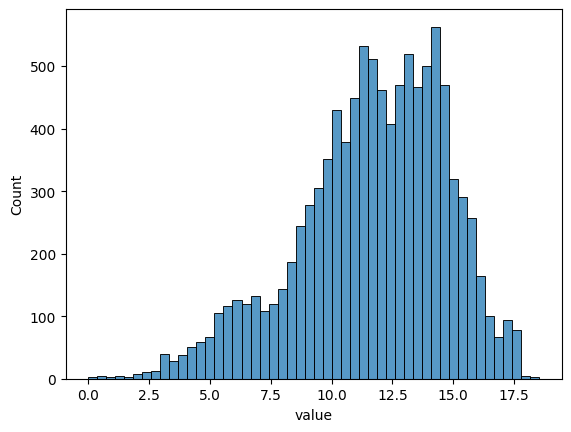

In [27]:
train['log_value'] = np.log(train['value'])

sns.histplot(np.log(train["value"]))
plt.show()

In [26]:
pivot_log = np.log1p(pivot_value_f)

# [9-2] dlog(차분) 생성
pivot_dlog = pivot_log.diff().dropna()

print("pivot_dlog shape:", pivot_dlog.shape)
pivot_dlog.head()

pivot_dlog shape: (0, 64)


hs4,1210,2002,2102,2501,2529,2807,2805,9403,8505,2811,...,7907,8461,8467,6006,4408,2701,9022,4810,7202,3813
date,,,,,,,,,,,,,,,,,,,,,


In [30]:
max_lag = 6
min_obs = 24
min_corr = 0.30   # dlog는 value보다 상관이 낮게 나옴

cols = pivot_dlog.columns.tolist()

results = []

for A in cols:
    sA = pivot_dlog[A]

    for B in cols:
        if A == B:
            continue

        sB0 =pivot_dlog[B]

        best_corr = None
        best_lag = None
        best_n = None

        for lag in range(1, max_lag+1):

            sB = sB0.shift(lag)

            valid = sA.notna() & sB.notna()
            n_obs = int(valid.sum())

            if n_obs < min_obs:
                continue

            corr = float(sA[valid].corr(sB[valid]))

            if np.isnan(corr):
                continue

            if (best_corr is None) or (corr > best_corr):
                best_corr = corr
                best_lag = lag
                best_n = n_obs

        if best_corr is None:
            continue

        if best_corr >= min_corr:
            results.append([A, B, best_lag, best_corr, best_n])

dlog_corr_df = pd.DataFrame(
    results,
    columns=['A','B','best_lag','best_corr','n_obs']
).sort_values(['best_corr','n_obs'], ascending=[False, False]).reset_index(drop=True)

print("dlog 기반 강한 공행성 후보 개수:", len(dlog_corr_df))
display(dlog_corr_df.head(20))


dlog 기반 강한 공행성 후보 개수: 0


,A,B,best_lag,best_corr,n_obs


In [29]:
print("pivot_dlog 전체 평균:", pivot_dlog.mean().mean())
print("pivot_dlog 전체 표준편차:", pivot_dlog.std().mean())

# 절댓값 기준 큰 값 확인
print("절댓값 상위 10개")
display(
    pivot_dlog.abs().stack().sort_values(ascending=False).head(10)
)

pivot_dlog 전체 평균: nan
pivot_dlog 전체 표준편차: nan
절댓값 상위 10개


,,0
date,hs4,


In [31]:
print("pivot_dlog shape:", pivot_dlog.shape)
print("pivot_dlog 전체 NaN 개수:", pivot_dlog.isna().sum().sum())
print("pivot_dlog 전체 non-NaN 개수:", pivot_dlog.notna().sum().sum())

# 행(월) 단위로 non-NaN이 하나라도 있는 행이 몇 개인지
print("non-NaN 있는 행 개수:", (pivot_dlog.notna().sum(axis=1) > 0).sum())

pivot_dlog shape: (0, 64)
pivot_dlog 전체 NaN 개수: 0
pivot_dlog 전체 non-NaN 개수: 0
non-NaN 있는 행 개수: 0


-> pivot_dlog 텅빔

In [32]:
print("pivot_value shape:", pivot_value.shape)
print("pivot_value non-NaN:", pivot_value.notna().sum().sum())

print("pivot_value_f shape:", pivot_value_f.shape)
print("pivot_value_f non-NaN:", pivot_value_f.notna().sum().sum())

# 열(품목)별 관측개월 수 요약
obs = pivot_value_f.notna().sum()
print(obs.describe())

pivot_value shape: (43, 71)
pivot_value non-NaN: 2682
pivot_value_f shape: (43, 64)
pivot_value_f non-NaN: 2646
count    64.000000
mean     41.343750
std       4.186974
min      26.000000
25%      43.000000
50%      43.000000
75%      43.000000
max      43.000000
dtype: float64


In [33]:
# (1) 관측개월 기준을 낮춤
min_months = 12

valid_cols = pivot_value.columns[pivot_value.notna().sum() >= min_months]
pv_f = pivot_value[valid_cols].copy()

# (2) 기준 완화
pv_f = pv_f.loc[:, pv_f.std(skipna=True) > 0]

print("pv_f shape:", pv_f.shape)
print("pv_f non-NaN:", pv_f.notna().sum().sum())

# (3) dlog 생성
pv_log = np.log1p(pv_f)
pivot_dlog = pv_log.diff()

# (4) dlog에서 '완전히 비어있는 행' 제거만 수행
# -> 행 전체가 NaN인 것만 제거
pivot_dlog = pivot_dlog.loc[pivot_dlog.notna().sum(axis=1) > 0]

print("pivot_dlog shape:", pivot_dlog.shape)
print("pivot_dlog non-NaN:", pivot_dlog.notna().sum().sum())


pv_f shape: (43, 64)
pv_f non-NaN: 2646
pivot_dlog shape: (42, 64)
pivot_dlog non-NaN: 2513


In [34]:
print("pivot_dlog 전체 평균:", pivot_dlog.stack().mean())
print("pivot_dlog 전체 표준편차:", pivot_dlog.stack().std())

display(pivot_dlog.abs().stack().sort_values(ascending=False).head(10))


pivot_dlog 전체 평균: -0.0011895137178288084
pivot_dlog 전체 표준편차: 1.2384243037232427


,,0
date,hs4,
2023-03-01,5512,11.357248
2023-02-01,5512,10.535889
2024-07-01,2701,8.426612
2022-10-01,7202,8.410185
2025-04-01,2701,7.309993
2022-11-01,7907,6.990257
2023-03-01,8461,6.937296
2022-09-01,2701,6.709345
2022-12-01,2701,6.609012


- 해결점 : dlog가 0인 이유
-> 기준이 너무 높음.

In [35]:
max_lag = 4
min_obs = 18
min_corr = 0.20

rows = []
cols = pivot_dlog.columns.tolist()

for A in cols:
    sA = pivot_dlog[A]
    for B in cols:
        if A == B:
            continue

        for lag in range(1, max_lag+1):
            sB = pivot_dlog[B].shift(lag)
            valid = sA.notna() & sB.notna()
            n = int(valid.sum())

            if n < min_obs:
                continue

            corr = sA[valid].corr(sB[valid])
            if pd.isna(corr):
                continue

            if corr >= min_corr:
                rows.append([A,B,lag,corr,n])

dlog_candidates = (
    pd.DataFrame(rows, columns=["A","B","lag","corr","n_obs"])
    .sort_values("corr", ascending=False)
    .reset_index(drop=True)
)

print("후보 개수:", len(dlog_candidates))
display(dlog_candidates.head(20))

후보 개수: 2305


,A,B,lag,corr,n_obs
0,2701,4202,3,0.738916,18
1,2841,4408,3,0.715376,18
2,3206,3806,3,0.692337,39
3,1210,7202,4,0.692090,21
4,8714,3813,1,0.684947,19
5,2701,5609,2,0.684239,18
6,2102,3038,1,0.675852,39
7,2701,3307,3,0.670685,18
8,3006,5119,2,0.651487,37
9,2701,3206,1,0.634689,19


In [39]:
cand = dlog_candidates.copy()

# 최소 표본, lag 범위 제한
min_obs_final = 20
max_lag_final = 4

cand2 = cand[(cand["n_obs"] >= min_obs_final) & (cand["lag"] <= max_lag_final)].copy()
print("필터 후 후보 개수:", len(cand2))
display(cand2.head(20))

필터 후 후보 개수: 1982


,A,B,lag,corr,n_obs
2,3206,3806,3,0.692337,39
3,1210,7202,4,0.692090,21
6,2102,3038,1,0.675852,39
8,3006,5119,2,0.651487,37
11,5512,5119,4,0.614793,33
12,2807,3307,1,0.614014,41
16,2846,2501,1,0.604740,41
18,3909,2002,1,0.600343,41
19,5512,2805,4,0.595384,36
20,2847,4802,2,0.589292,40


In [40]:
best_pairs = (
    cand2.sort_values(["A","B","corr"], ascending=[True, True, False])
         .drop_duplicates(["A","B"])
         .sort_values(["corr","n_obs"], ascending=[False, False])
         .reset_index(drop=True)
)

display(best_pairs.head(20))

,A,B,lag,corr,n_obs
0,3206,3806,3,0.692337,39
1,1210,7202,4,0.692090,21
2,2102,3038,1,0.675852,39
3,3006,5119,2,0.651487,37
4,5512,5119,4,0.614793,33
5,2807,3307,1,0.614014,41
6,2846,2501,1,0.604740,41
7,3909,2002,1,0.600343,41
8,5512,2805,4,0.595384,36
9,2847,4802,2,0.589292,40


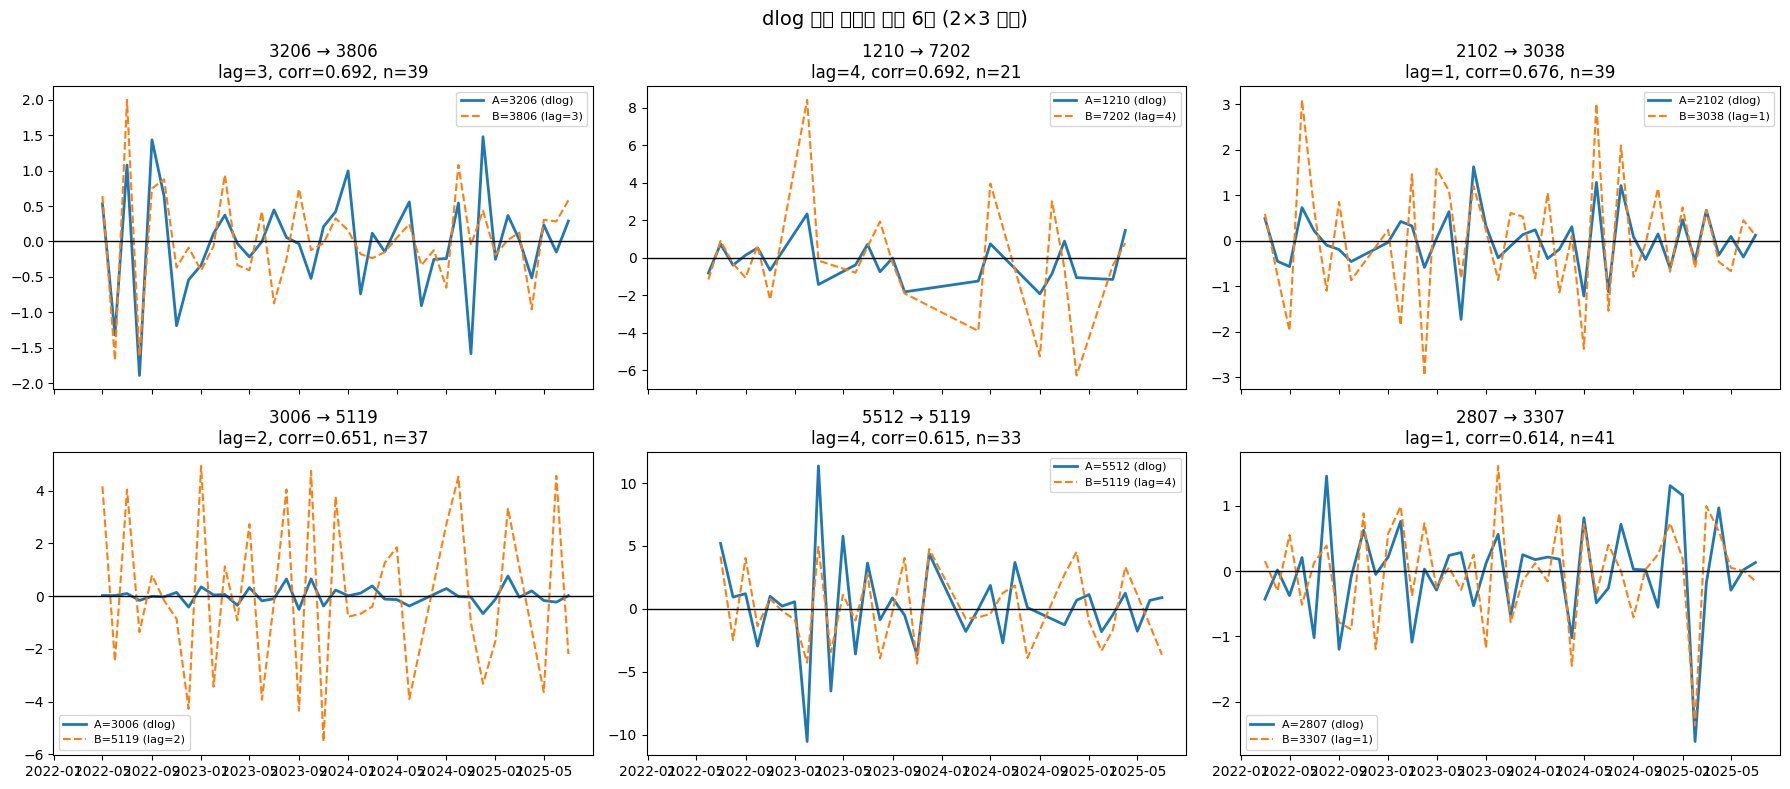

In [41]:
# 상위 6개
top6 = best_pairs.head(6)[["A","B","lag","corr","n_obs"]].values.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True)
axes = axes.ravel()

for ax, (A, B, lag, corr, n_obs) in zip(axes, top6):
    A = int(A)
    B = int(B)
    lag = int(lag)

    # dlog 시계열
    sA = pivot_dlog[A]
    sB = pivot_dlog[B].shift(lag)  # B를 과거로 밀어 A가 선행하는 구조로 정렬

    valid = sA.notna() & sB.notna()

    ax.plot(pivot_dlog.index[valid], sA[valid],
            label=f"A={A} (dlog)", linewidth=2)

    ax.plot(pivot_dlog.index[valid], sB[valid],
            label=f"B={B} (lag={lag})",
            linestyle="--")

    ax.axhline(0, color="black", linewidth=1)

    ax.set_title(f"{A} → {B}\nlag={lag}, corr={corr:.3f}, n={int(n_obs)}")
    ax.legend(fontsize=8)

plt.suptitle("dlog 기반 공행성 상위 6개 (2×3 비교)", fontsize=14)
plt.tight_layout()
plt.show()

In [44]:
pairs_3 = [
    (3206, 3806, 3),
    (2102, 3038, 1),
    (2807, 3307, 1),
]

score_rows = []
models = {}

val_months = 3  # 최근 3개월 검증

for A, B, lag in pairs_3:

    # --- 선행/후행 데이터 정렬 ---
    sA = pivot_dlog[A].shift(lag)
    sB = pivot_dlog[B]
    sB_lag1 = sB.shift(1)

    dfm = pd.DataFrame({
        "A": sA,
        "B_lag1": sB_lag1,
        "y": sB
    }).dropna()

    if len(dfm) < val_months + 10:
        continue

    X = dfm[["A", "B_lag1"]]
    y = dfm["y"]

    X_train = X.iloc[:-val_months]
    y_train = y.iloc[:-val_months]

    X_val = X.iloc[-val_months:]
    y_val = y.iloc[-val_months:]

    model = HistGradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)

    pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, pred)

    score_rows.append([A, B, lag, len(dfm), mae])
    models[(A, B, lag)] = model

score_df = pd.DataFrame(score_rows,
                        columns=["A","B","lag","n_samples","val_MAE_dlog"])

score_df = score_df.sort_values("val_MAE_dlog").reset_index(drop=True)

display(score_df)

,A,B,lag,n_samples,val_MAE_dlog
0,2807,3307,1,41,0.062484
1,2102,3038,1,38,0.249519
2,3206,3806,3,39,0.817459


- 2807→3307은:
corr은 약간 낮았지만
예측 성능이 압도적으로 좋음

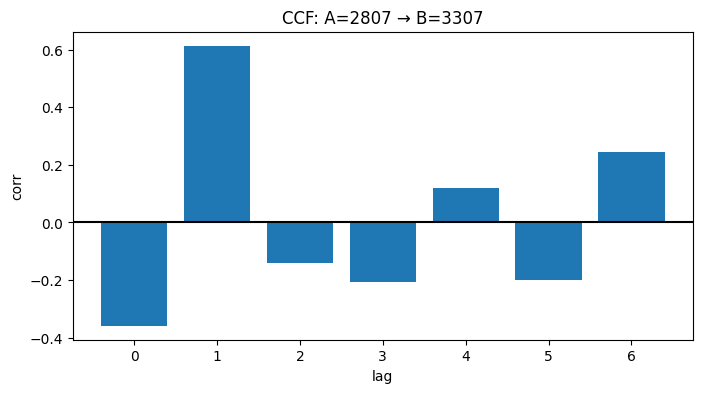

lag=0 : corr=-0.3587
lag=1 : corr=0.6140
lag=2 : corr=-0.1422
lag=3 : corr=-0.2053
lag=4 : corr=0.1213
lag=5 : corr=-0.2011
lag=6 : corr=0.2440


In [45]:
# ccf 재확인
A = 2807
B = 3307

max_lag = 6

ccf_vals = []

for lag in range(0, max_lag+1):
    corr = pivot_dlog[A].corr(pivot_dlog[B].shift(lag))
    ccf_vals.append(corr)

# 그래프
plt.figure(figsize=(8,4))
plt.bar(range(0, max_lag+1), ccf_vals)
plt.axhline(0, color='black')
plt.title(f"CCF: A={A} → B={B}")
plt.xlabel("lag")
plt.ylabel("corr")
plt.xticks(range(0, max_lag+1))
plt.show()

# 숫자도 같이 출력
for lag, val in enumerate(ccf_vals):
    print(f"lag={lag} : corr={val:.4f}")

In [46]:
A = 2807
B = 3307

df_granger = pd.DataFrame({
    "B": pivot_dlog[B],
    "A": pivot_dlog[A]
}).dropna()

print("Granger Test (A → B)")
grangercausalitytests(df_granger[["B","A"]], maxlag=3, verbose=True)

Granger Test (A → B)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9540 , p=0.0021  , df_denom=38, df_num=1
ssr based chi2 test:   chi2=11.8188 , p=0.0006  , df=1
likelihood ratio test: chi2=10.3851 , p=0.0013  , df=1
parameter F test:         F=10.9540 , p=0.0021  , df_denom=38, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3157  , p=0.0480  , df_denom=35, df_num=2
ssr based chi2 test:   chi2=7.5788  , p=0.0226  , df=2
likelihood ratio test: chi2=6.9403  , p=0.0311  , df=2
parameter F test:         F=3.3157  , p=0.0480  , df_denom=35, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9788  , p=0.1369  , df_denom=32, df_num=3
ssr based chi2 test:   chi2=7.2350  , p=0.0648  , df=3
likelihood ratio test: chi2=6.6368  , p=0.0844  , df=3
parameter F test:         F=1.9788  , p=0.1369  , df_denom=32, df_num=3


{np.int64(1): ({'ssr_ftest': (np.float64(10.953996143429658),
    np.float64(0.002052401647672518),
    np.float64(38.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(11.818785312647789),
    np.float64(0.0005863610098716725),
    np.int64(1)),
   'lrtest': (np.float64(10.385088569923113),
    np.float64(0.0012703709360115953),
    np.int64(1)),
   'params_ftest': (np.float64(10.953996143429663),
    np.float64(0.0020524016476725125),
    np.float64(38.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(3.3157300609557327),
    np.float64(0.04800782427489853),
    np.float64(35.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(7.578811567898818),
    np.float64(0.02260903251037602),
    np.int64(2)),
   'lrtest': (np.float64(6.94032291572843),
    np.float64(0.031112006977317145),
    np.int64(2)),
   'params_ftest': (np.float64(3.3157300609557354),
    np.float64(0.04800782427489842),
    np.float64(35.0),
    2.0)},
   array([[0., 0., 1., 0., 0.

- lag=1에서 매우 유의 (p=0.002)
- lag=2도 유의
- lag=3부터 사라짐

🎯 결론

2807 → 3307 (lag=1)
CCF에서 lag=1 최대
Granger 유의
MAE 가장 낮음 (0.062)
표본 충분 (41)

### 학습

In [47]:
# 최종 선택
A = 2807
B = 3307
lag = 1

# 전체 데이터로 재학습
sA = pivot_dlog[A].shift(lag)
sB = pivot_dlog[B]
sB_lag1 = sB.shift(1)

df_final = pd.DataFrame({
    "A": sA,
    "B_lag1": sB_lag1,
    "y": sB
}).dropna()

X = df_final[["A","B_lag1"]]
y = df_final["y"]

final_model = HistGradientBoostingRegressor(random_state=42)
final_model.fit(X, y)

# 마지막 관측 기준 다음달 예측
X_last = X.iloc[[-1]]
pred_dlog = float(final_model.predict(X_last)[0])

print("예측 dlog:", pred_dlog)


예측 dlog: 0.5130284571829518


In [48]:
# 마지막 실제 log값
last_log = np.log1p(pivot_value.loc[pivot_value.index.max(), B])

# 다음달 log 예측
next_log = last_log + pred_dlog

# value 복원
pred_value = np.expm1(next_log)

print(f"2025-08 B={B} 예상 총 무역량(value) = {pred_value:,.2f}")


2025-08 B=3307 예상 총 무역량(value) = 202,365.96


시각화

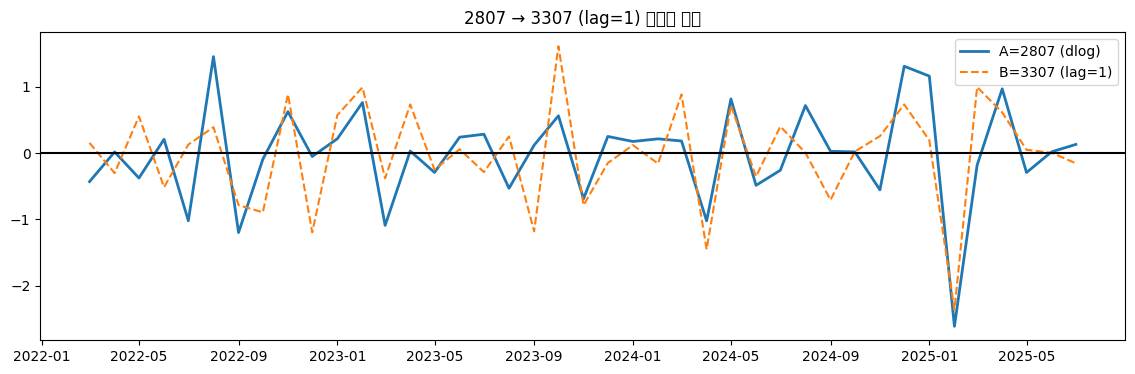

In [49]:
plt.figure(figsize=(14,4))

sA = pivot_dlog[2807]
sB = pivot_dlog[3307].shift(1)

valid = sA.notna() & sB.notna()

plt.plot(pivot_dlog.index[valid], sA[valid], label="A=2807 (dlog)", linewidth=2)
plt.plot(pivot_dlog.index[valid], sB[valid], label="B=3307 (lag=1)", linestyle="--")

plt.axhline(0, color='black')
plt.title("2807 → 3307 (lag=1) 선후행 구조")
plt.legend()
plt.show()

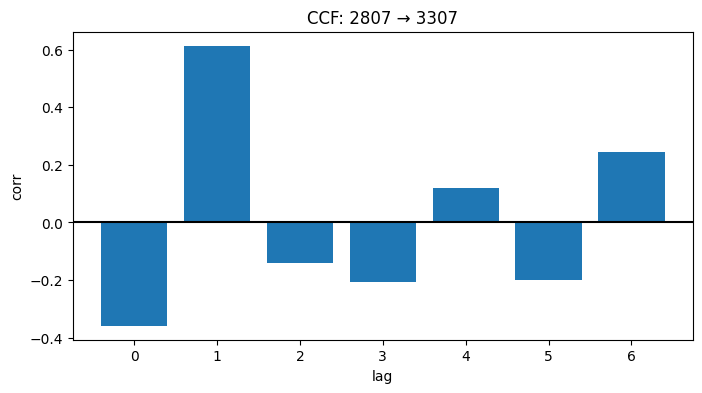

In [50]:
max_lag = 6
ccf_vals = [pivot_dlog[2807].corr(pivot_dlog[3307].shift(l)) for l in range(max_lag+1)]

plt.figure(figsize=(8,4))
plt.bar(range(max_lag+1), ccf_vals)
plt.axhline(0, color='black')
plt.title("CCF: 2807 → 3307")
plt.xlabel("lag")
plt.ylabel("corr")
plt.show()

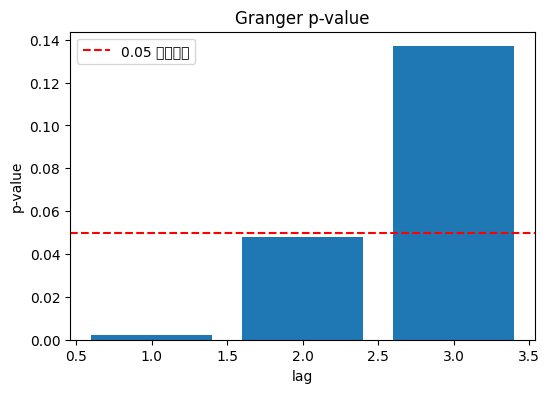

In [51]:
lags = [1,2,3]
pvals = [0.0021, 0.0480, 0.1369]  # 네 출력값 기준

plt.figure(figsize=(6,4))
plt.bar(lags, pvals)
plt.axhline(0.05, color='red', linestyle='--', label='0.05 유의수준')
plt.title("Granger p-value")
plt.xlabel("lag")
plt.ylabel("p-value")
plt.legend()
plt.show()

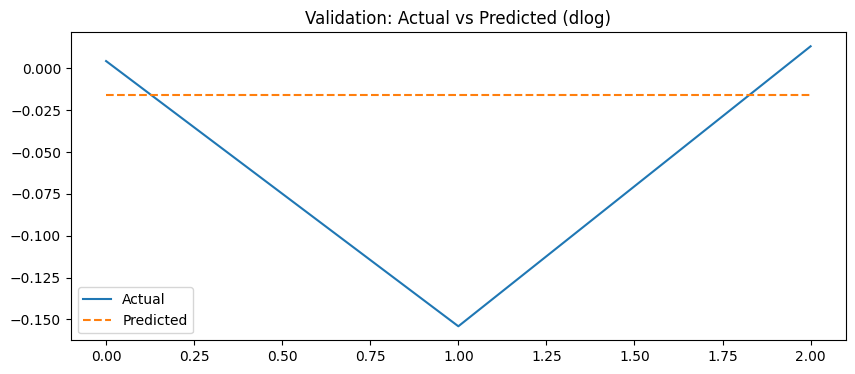

In [52]:
# 예측 모델 성능
plt.figure(figsize=(10,4))

plt.plot(y_val.values, label="Actual")
plt.plot(pred, label="Predicted", linestyle="--")

plt.title("Validation: Actual vs Predicted (dlog)")
plt.legend()
plt.show()

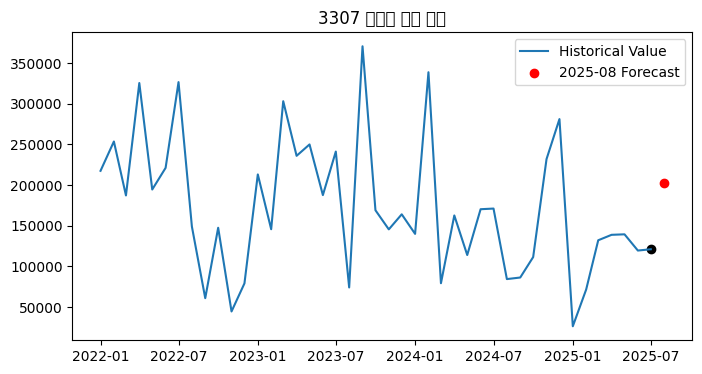

In [53]:
plt.figure(figsize=(8,4))

plt.plot(pivot_value[3307], label="Historical Value")
plt.scatter(pivot_value.index.max(),
            pivot_value.loc[pivot_value.index.max(),3307],
            color='black')

plt.scatter(pivot_value.index.max() + pd.DateOffset(months=1),
            pred_value,
            color='red',
            label="2025-08 Forecast")

plt.title("3307 무역량 예측 결과")
plt.legend()
plt.show()


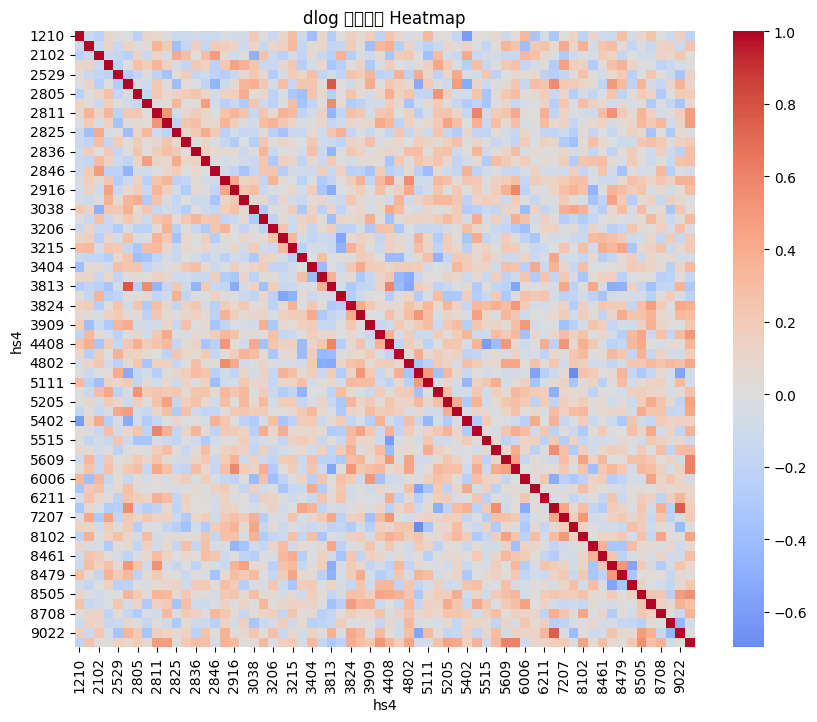

In [54]:
import seaborn as sns

corr_matrix = pivot_dlog.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("dlog 상관행렬 Heatmap")
plt.show()
